In [1]:
# !pip install numpy==1.19.5
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
# !pip install scikit-learn
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Deepfake",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4331 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['Fake', 'Real']

In [6]:
len(dataset)

136

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0]


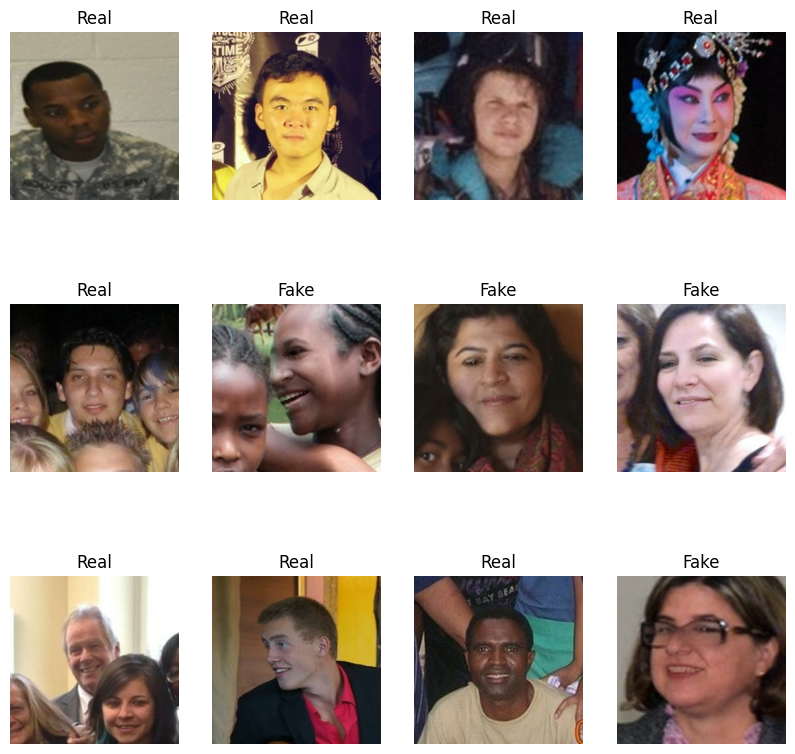

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

108.80000000000001

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

108

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])


In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
108/108 [==============================] - 46s 273ms/step - loss: 0.6674 - accuracy: 0.5921 - val_loss: 0.5938 - val_accuracy: 0.6899
Epoch 2/50
108/108 [==============================] - 23s 215ms/step - loss: 0.4852 - accuracy: 0.7753 - val_loss: 0.4951 - val_accuracy: 0.8053
Epoch 3/50
108/108 [==============================] - 23s 215ms/step - loss: 0.3862 - accuracy: 0.8364 - val_loss: 0.3419 - val_accuracy: 0.8486
Epoch 4/50
108/108 [==============================] - 23s 215ms/step - loss: 0.3237 - accuracy: 0.8693 - val_loss: 0.3383 - val_accuracy: 0.8510
Epoch 5/50
108/108 [==============================] - 23s 214ms/step - loss: 0.3020 - accuracy: 0.8830 - val_loss: 0.3011 - val_accuracy: 0.8774
Epoch 6/50
108/108 [==============================] - 23s 215ms/step - loss: 0.2992 - accuracy: 0.8812 - val_loss: 0.3001 - val_accuracy: 0.8870
Epoch 7/50
108/108 [==============================] - 23s 213ms/step - loss: 0.2709 - accuracy: 0.8969 - val_loss: 0.3055 - val_ac

In [21]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 3s 42ms/step - loss: 0.1373 - accuracy: 0.9542


In [23]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step
actual_class Real, predicted_class Real, confidence 85.48
1/1 [==============================] - 0s 24ms/step
actual_class Real, predicted_class Real, confidence 72.14
1/1 [==============================] - 0s 25ms/step
actual_class Fake, predicted_class Fake, confidence 96.71
1/1 [==============================] - 0s 30ms/step
actual_class Fake, predicted_class Fake, confidence 99.9
1/1 [==============================] - 0s 41ms/step
actual_class Real, predicted_class Real, confidence 99.96
1/1 [==============================] - 0s 25ms/step
actual_class Fake, predicted_class Fake, confidence 63.49
1/1 [==============================] - 0s 31ms/step
actual_class Fake, predicted_class Fake, confidence 55.91
1/1 [==============================] - 0s 24ms/step
actual_class Real, predicted_class Real, confidence 99.35
1/1 [==============================] - 0s 30ms/step
actual_class Real, predicted_class Real, confidence 99.34


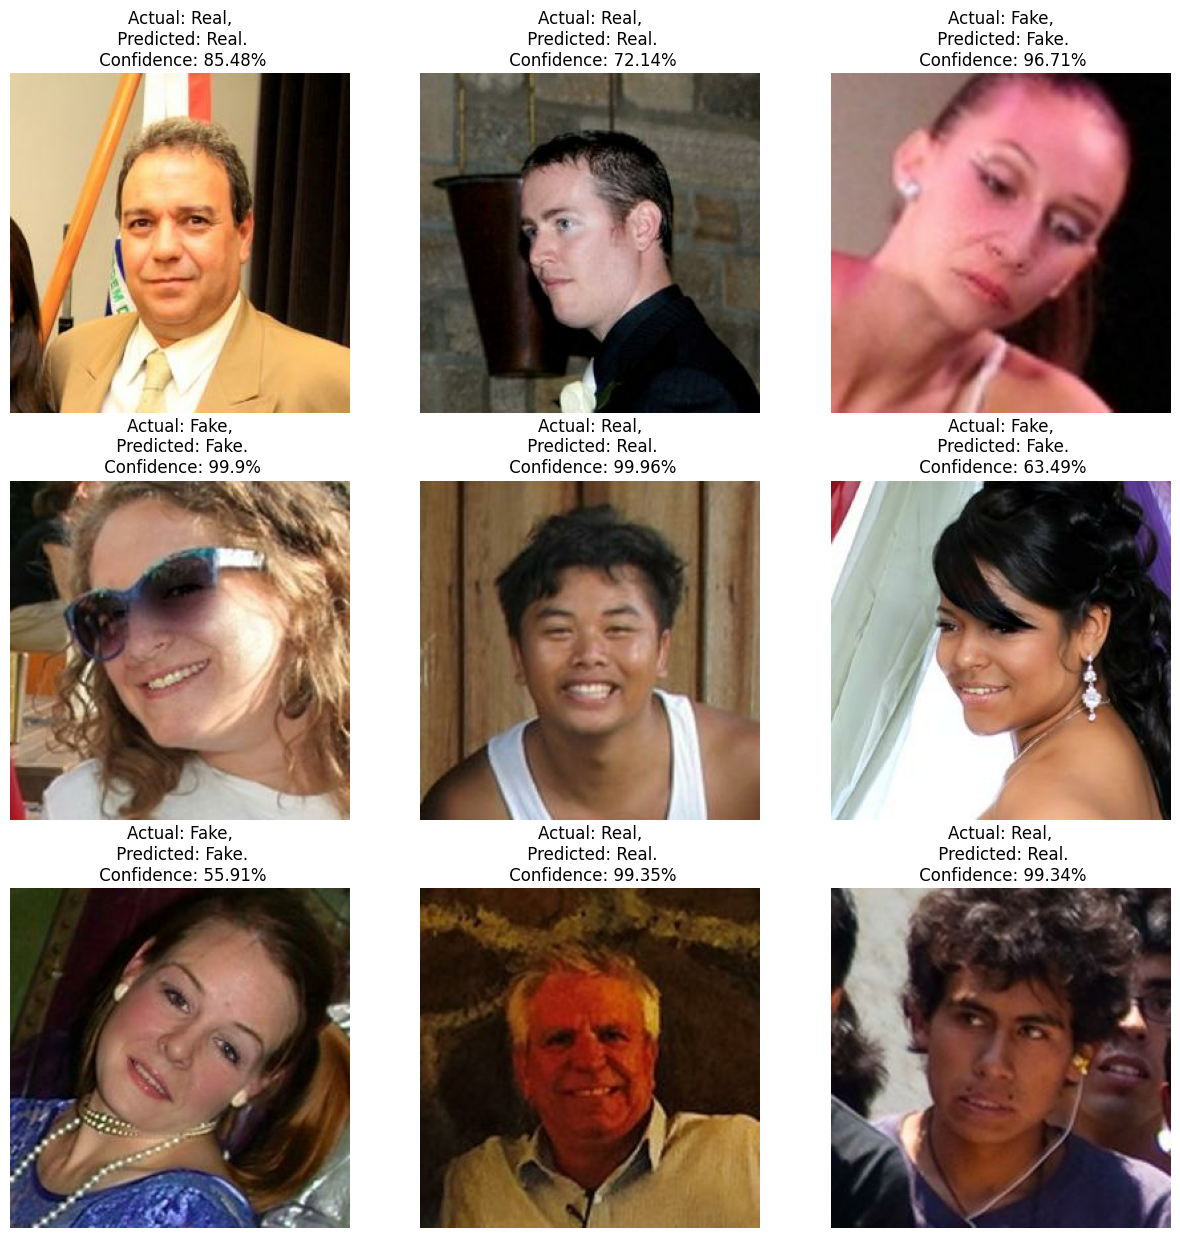

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        plt.savefig('testPic')
        print(f"actual_class {actual_class}, predicted_class {predicted_class}, confidence {confidence}")

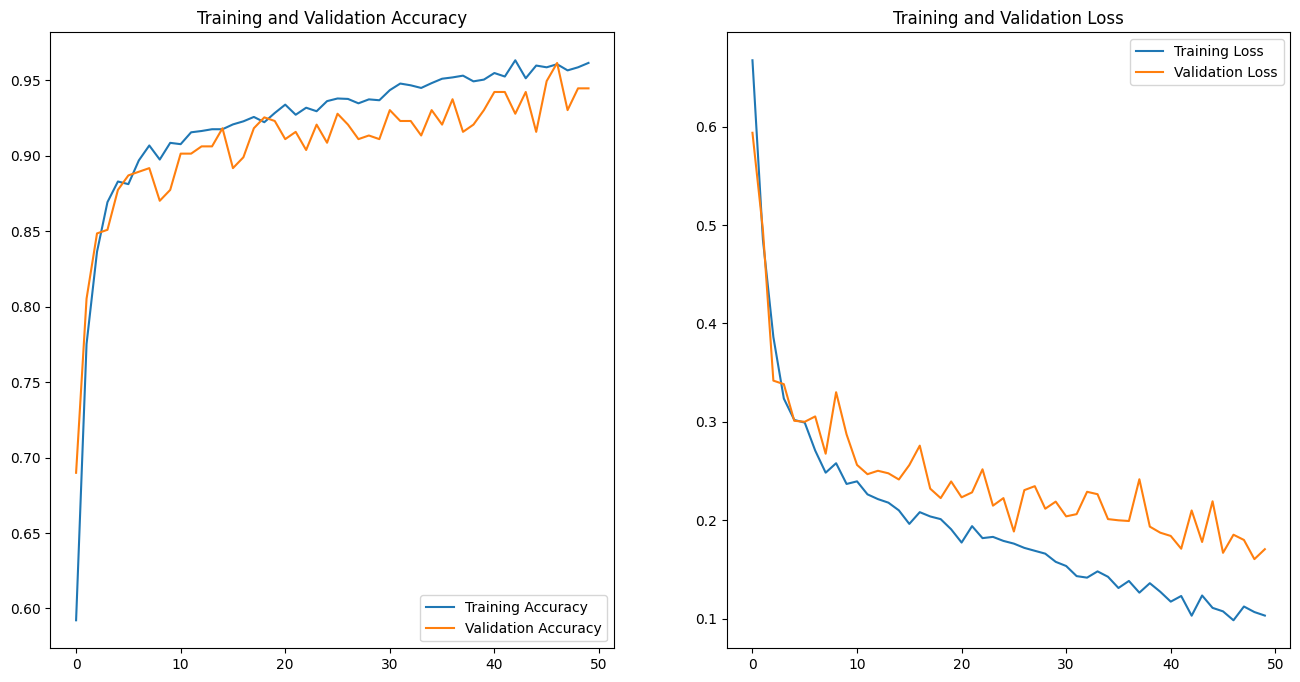

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('Training and Validation Accuracy')

1/1 [==============================] - 0s 41ms/step


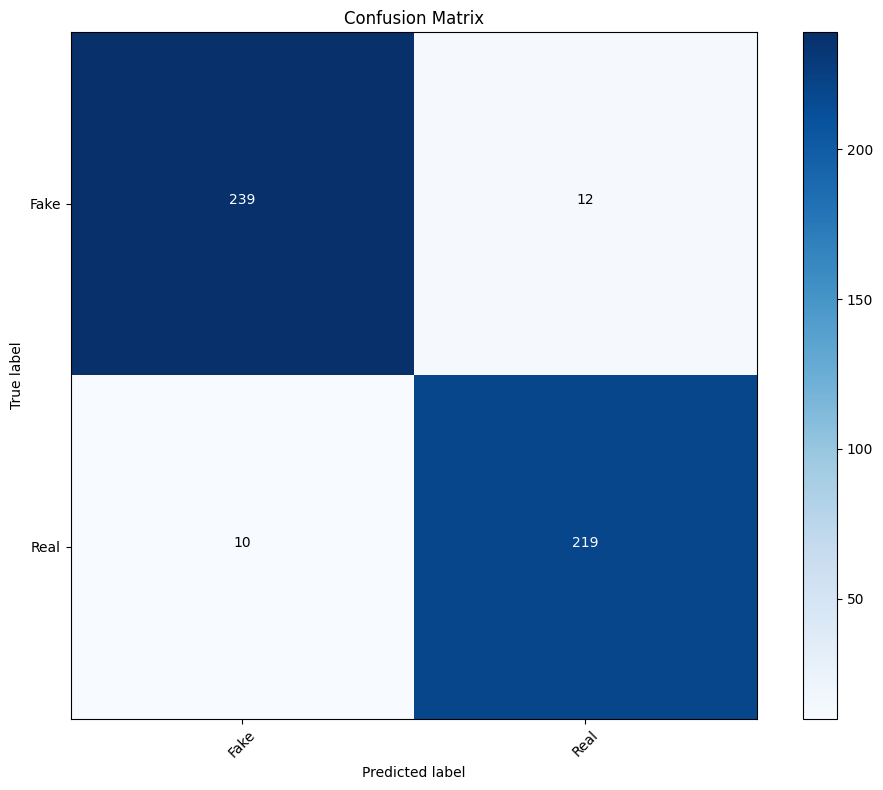

<Figure size 640x480 with 0 Axes>

In [40]:
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = conf_mat.max() / 2.
for i, j in np.ndindex(conf_mat.shape):
    plt.text(j, i, format(conf_mat[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_mat[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
plt.savefig('Deepfake Cm')

In [41]:
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

        Fake       0.96      0.95      0.96       251
        Real       0.95      0.96      0.95       229

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480

